In [1]:
import normflows as nf

import torch
import numpy as np
from nf_class import SystematicFlow  


# -----------------------------------------------------------------------------
# Dummy Flow Layer (Now Subclassing nn.Module)
# -----------------------------------------------------------------------------
import torch.nn as nn

class DummyFlow(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, z, context=None):
        # Return the input unchanged and zero log determinant
        return z, torch.zeros(z.shape[0], device=z.device)
    
    def inverse(self, x, context=None):
        # Return the input unchanged and zero log determinant
        return x, torch.zeros(x.shape[0], device=x.device)

# -----------------------------------------------------------------------------
# Dummy Base Distribution (q0)
# -----------------------------------------------------------------------------
class DummyBaseDistribution:
    def __init__(self, shape=(2,)):
        self.shape = shape

    def __call__(self, num_samples=1, context=None):
        # Sample standard normal and return zero log probability
        z = torch.randn(num_samples, *self.shape)
        log_q = torch.zeros(num_samples, device=z.device)
        return z, log_q

    def log_prob(self, z, context=None):
        # Return zero log probability
        return torch.zeros(z.shape[0], device=z.device)

# -----------------------------------------------------------------------------
# Dummy Target Distribution (p)
# -----------------------------------------------------------------------------
class DummyTargetDistribution:
    def log_prob(self, i, pedestal=None):
        # Return dummy outputs for z, context, and log_p
        z = torch.randn(4, 2)
        context = torch.zeros(4, 1)
        log_p = torch.zeros(4)
        return z, context, log_p

# -----------------------------------------------------------------------------
# Testing SystematicFlow
# -----------------------------------------------------------------------------
if __name__ == "__main__":
    # Define dummy components
    flows = [DummyFlow(), DummyFlow()]  # Two dummy flows
    q0 = DummyBaseDistribution(shape=(2,))
    p = DummyTargetDistribution()

    # Create an instance of SystematicFlow
    flow = SystematicFlow(flows=flows, q0=q0, p=p)

    # Test forward pass
    z = torch.randn(5, 2)  # Latent variable
    x = flow.forward(z)
    print("Forward pass output:", x)

    # Test forward and log determinant
    x, log_det = flow.forward_and_log_det(z)
    print("Forward and log determinant output:", x, log_det)

    # Test inverse pass
    x_rand = torch.randn(5, 2)
    z = flow.inverse(x_rand)
    print("Inverse pass output:", z)

    # Test inverse and log determinant
    z, log_det = flow.inverse_and_log_det(x_rand)
    print("Inverse and log determinant output:", z, log_det)

    # Test sampling
    samples, log_prob = flow.sample(num_samples=3)
    print("Sampled data:", samples)
    print("Log probability of samples:", log_prob)

    # Test log probability
    log_prob = flow.log_prob(x_rand)
    print("Log probability of input:", log_prob)

    # Test symmetric KLD
    sym_kld = flow.symmetric_kld(i=0)
    print("Symmetric KLD:", sym_kld)



Forward pass output: tensor([[-0.2995,  0.4891],
        [ 0.2056,  0.7329],
        [-0.1551,  0.2168],
        [ 1.2995,  0.2195],
        [ 0.3567,  0.2479]])
Forward and log determinant output: tensor([[-0.2995,  0.4891],
        [ 0.2056,  0.7329],
        [-0.1551,  0.2168],
        [ 1.2995,  0.2195],
        [ 0.3567,  0.2479]]) tensor([0., 0., 0., 0., 0.])
Inverse pass output: tensor([[-0.2035,  0.5068],
        [ 2.4945,  1.2355],
        [ 1.4056, -0.4199],
        [-0.1156, -1.4401],
        [ 0.0059,  0.5096]])
Inverse and log determinant output: tensor([[-0.2035,  0.5068],
        [ 2.4945,  1.2355],
        [ 1.4056, -0.4199],
        [-0.1156, -1.4401],
        [ 0.0059,  0.5096]]) tensor([0., 0., 0., 0., 0.])
Sampled data: tensor([[ 1.8469,  0.5513],
        [-1.5191,  0.9440],
        [ 0.4747,  0.8791]])
Log probability of samples: tensor([0., 0., 0.])
Log probability of input: tensor([0., 0., 0., 0., 0.])
Symmetric KLD: tensor(0.)


In [18]:
import numpy as np

# Parameters
n_samples = 200000  # Total number of samples
n_dim = 5          # Dimensionality of the data

# Generate random mean for the first Gaussian in the original space
mean1 = np.random.randn(n_dim)*2   # Scaled for variety

# Generate the covariance matrix (positive definite) in the original space
diag_values = np.random.uniform(0, 2, size=n_dim)  # Random values in [0, 2] for the diagonal
cov = np.diag(diag_values)  # Diagonal covariance matrix
chol_cov = np.linalg.cholesky(cov)     # Cholesky decomposition for sampling
sigma = np.sqrt(np.diag(cov))          # Standard deviations (sqrt of variances)


# Generate the mean for the second Gaussian 
mean2 = - mean1 

# Generate samples from a standard Gaussian in the eigenspace
data_eigen = np.random.randn(n_samples, n_dim)  # Samples from N(0, I)

# Transform data back to the original space for computing log-probabilities
data_original = data_eigen

# Precompute NLL for the true mixture distribution
log_p_values = []
weights = []  # Store weights for later use
inv_cov = np.linalg.inv(cov)
sign, logdet_cov = np.linalg.slogdet(cov)
assert sign > 0, "Covariance must be positive-definite."
normalizing_const = 0.5 * (n_dim * np.log(2 * np.pi))

for x in data_original:
    # Compute NLL for both components
    diff1 = x - mean1
    diff2 = x - mean2
    mahal1 = diff1 @ inv_cov @ diff1  # Mahalanobis distance for Gaussian 1
    mahal2 = diff2 @ inv_cov @ diff2  # Mahalanobis distance for Gaussian 2

    # Log probability for each component
    log_p1 = -normalizing_const - 0.5 * mahal1
    log_p2 = -normalizing_const - 0.5 * mahal2

    # Mixture log probability using log-sum-exp trick
    max_log_p = max(log_p1, log_p2)
    log_p_total = max_log_p + np.log(np.exp(log_p1 - max_log_p) + np.exp(log_p2 - max_log_p))

    log_p_values.append(-log_p_total)  # Store NLL (negative log-probability)
    weights.append(np.exp(-log_p_total))  # Compute weight as exp(-NLL)

log_p = np.array(log_p_values)
weights = np.array(weights)

# Compute weighted mean
weighted_sum = np.sum(weights[:, None] * data_original, axis=0)
approx_mean = weighted_sum / np.sum(weights)


# Save the dataset
np.savez(
    'synthetic_double_gaussian_5D_eigenspace_weighted.npz',
    data=data_eigen,   # Samples in the eigenspace (N(0, I))
    mean=mean1*0,  # Weighted mean (Gaussian approximation)
    cov=cov,    # Weighted covariance (Gaussian approximation)
    log_p=log_p        # NLL under the true mixture (from original space)
)

print("5D synthetic dataset (double Gaussian with eigenspace samples and weighted approximation) saved to 'synthetic_double_gaussian_5D_eigenspace_weighted.npz'.")




[[2.61440791 0.         0.         0.         0.        ]
 [0.         1.01088177 0.         0.         0.        ]
 [0.         0.         1.11670822 0.         0.        ]
 [0.         0.         0.         0.58910673 0.        ]
 [0.         0.         0.         0.         1.10822936]]
5D synthetic dataset (double Gaussian with eigenspace samples and weighted approximation) saved to 'synthetic_double_gaussian_5D_eigenspace_weighted.npz'.


Number of samples: 200000
Data dimensionality: 5

Sample index 42 =>
  single_gaussian_log_density (standard Gauss NLL): tensor([0.9206, 0.9604, 0.9231, 0.9451, 0.9689])
  negative_log_p (precomputed): tensor(18.4264)
tensor([1.4072e-09, 4.2689e-07, 5.8858e-09,  ..., 3.2479e-08, 3.6983e-09,
        3.2390e-09])


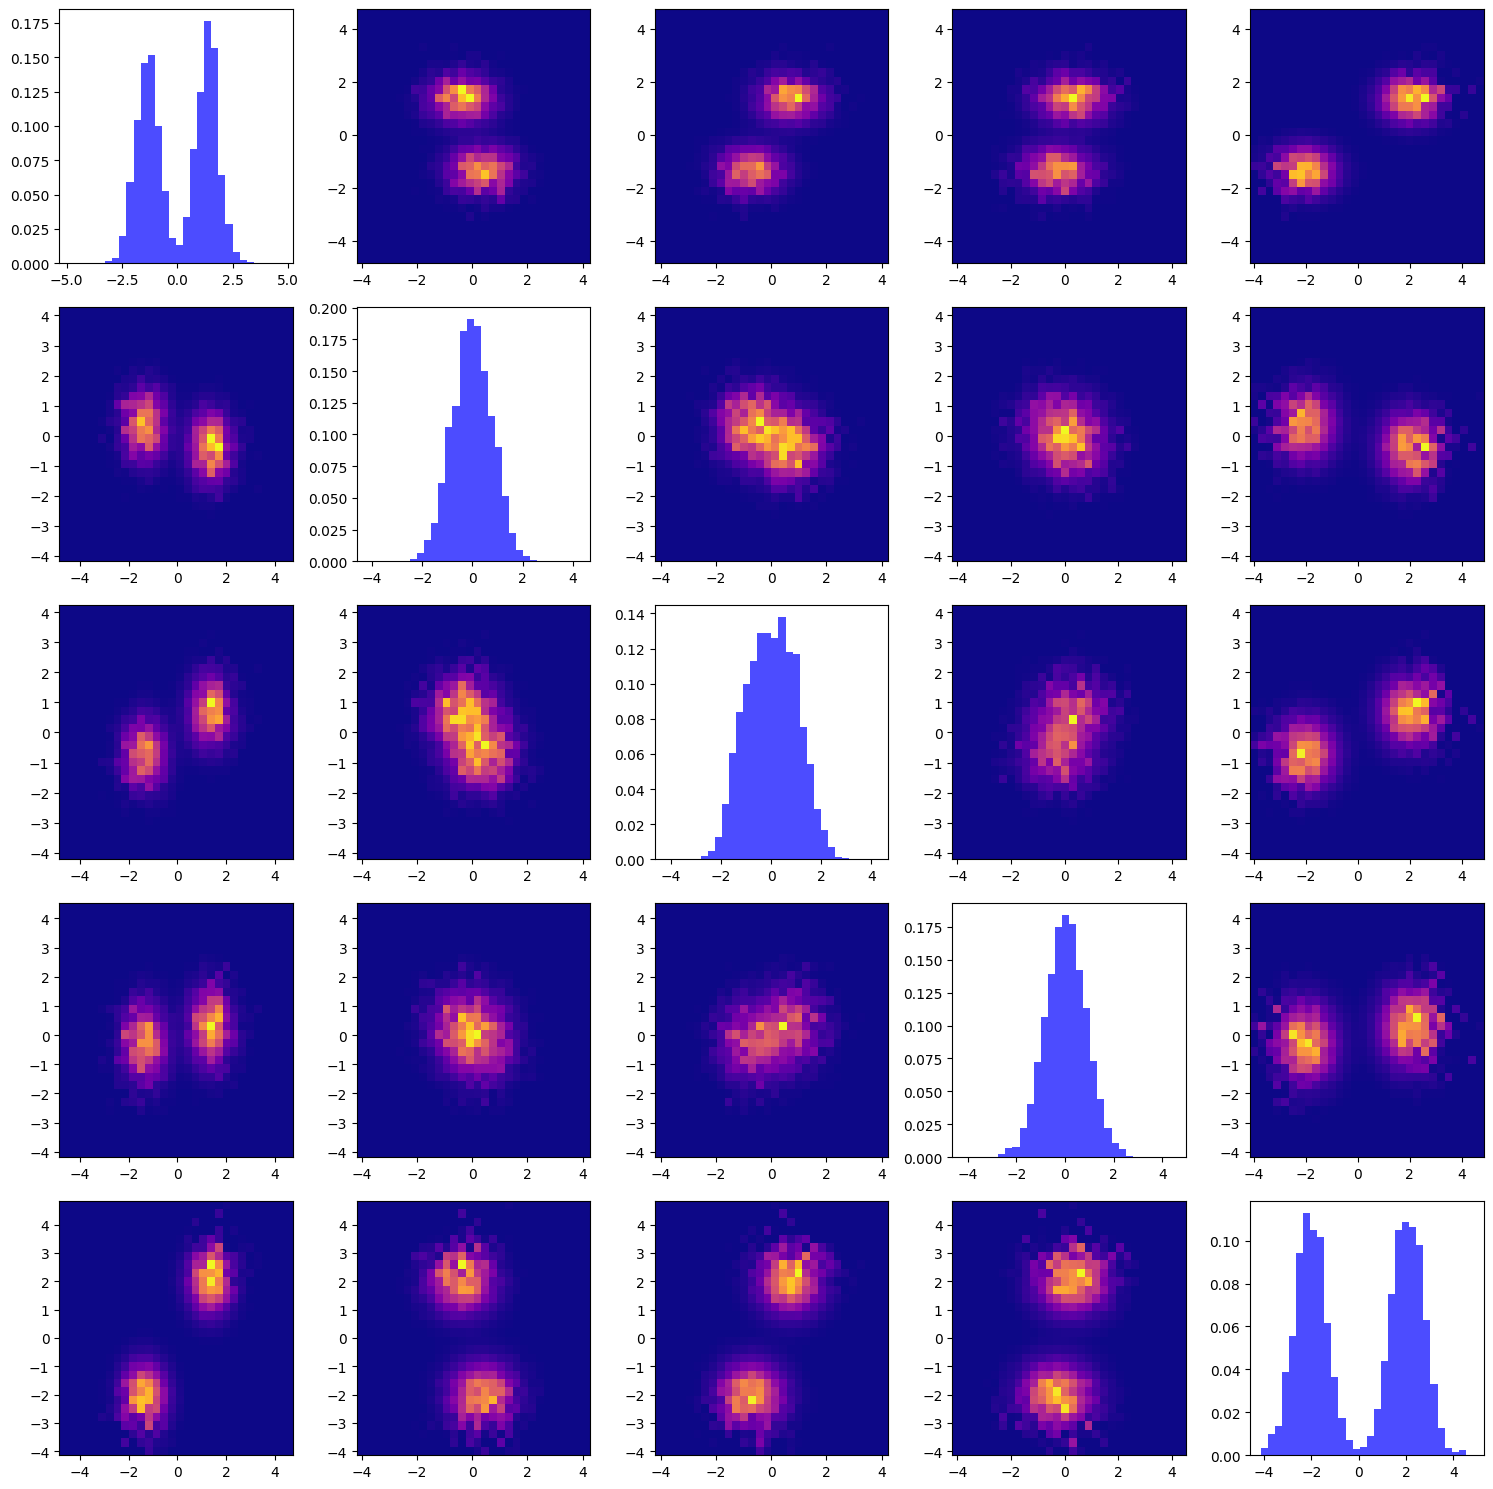

tensor([1.4072e-09, 4.2689e-07, 5.8858e-09,  ..., 3.2479e-08, 3.6983e-09,
        3.2390e-09])


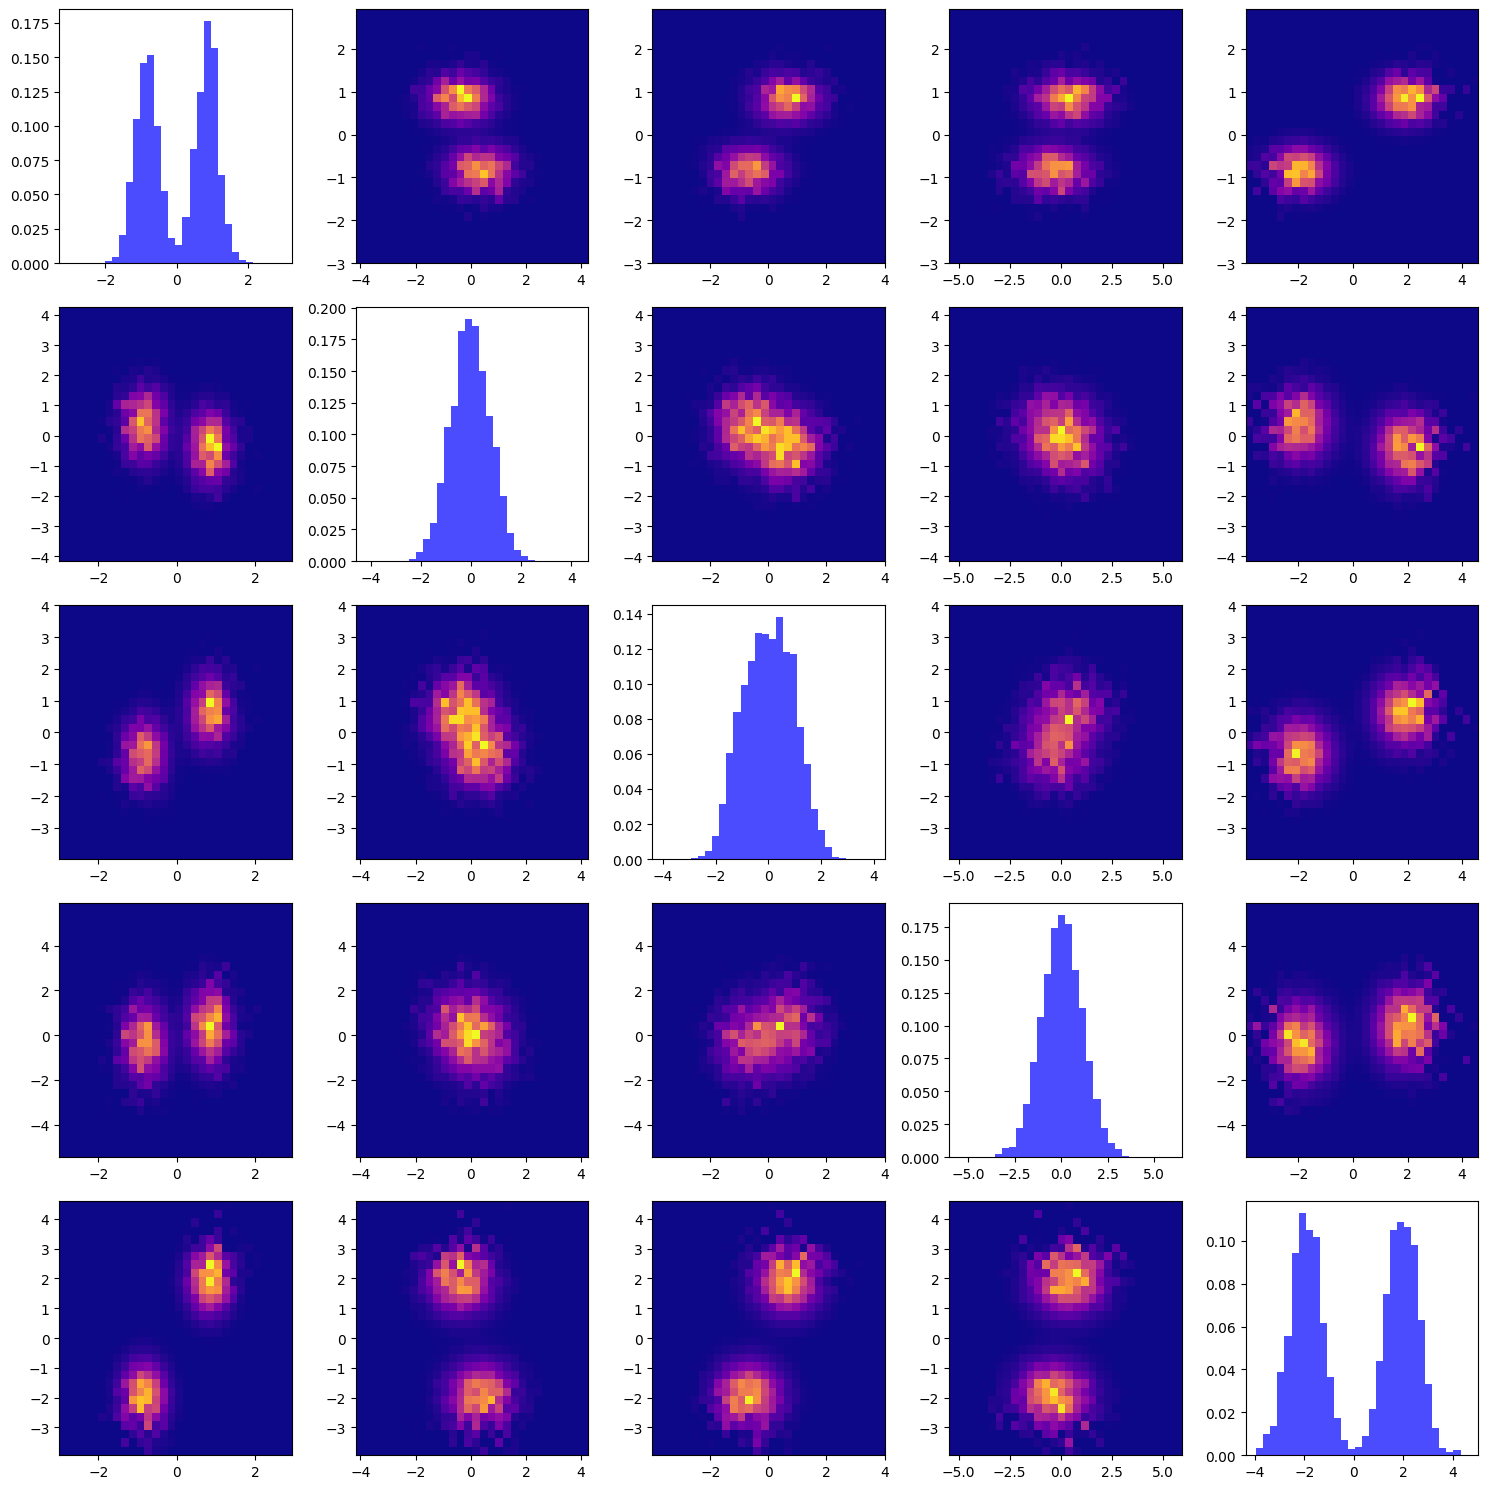

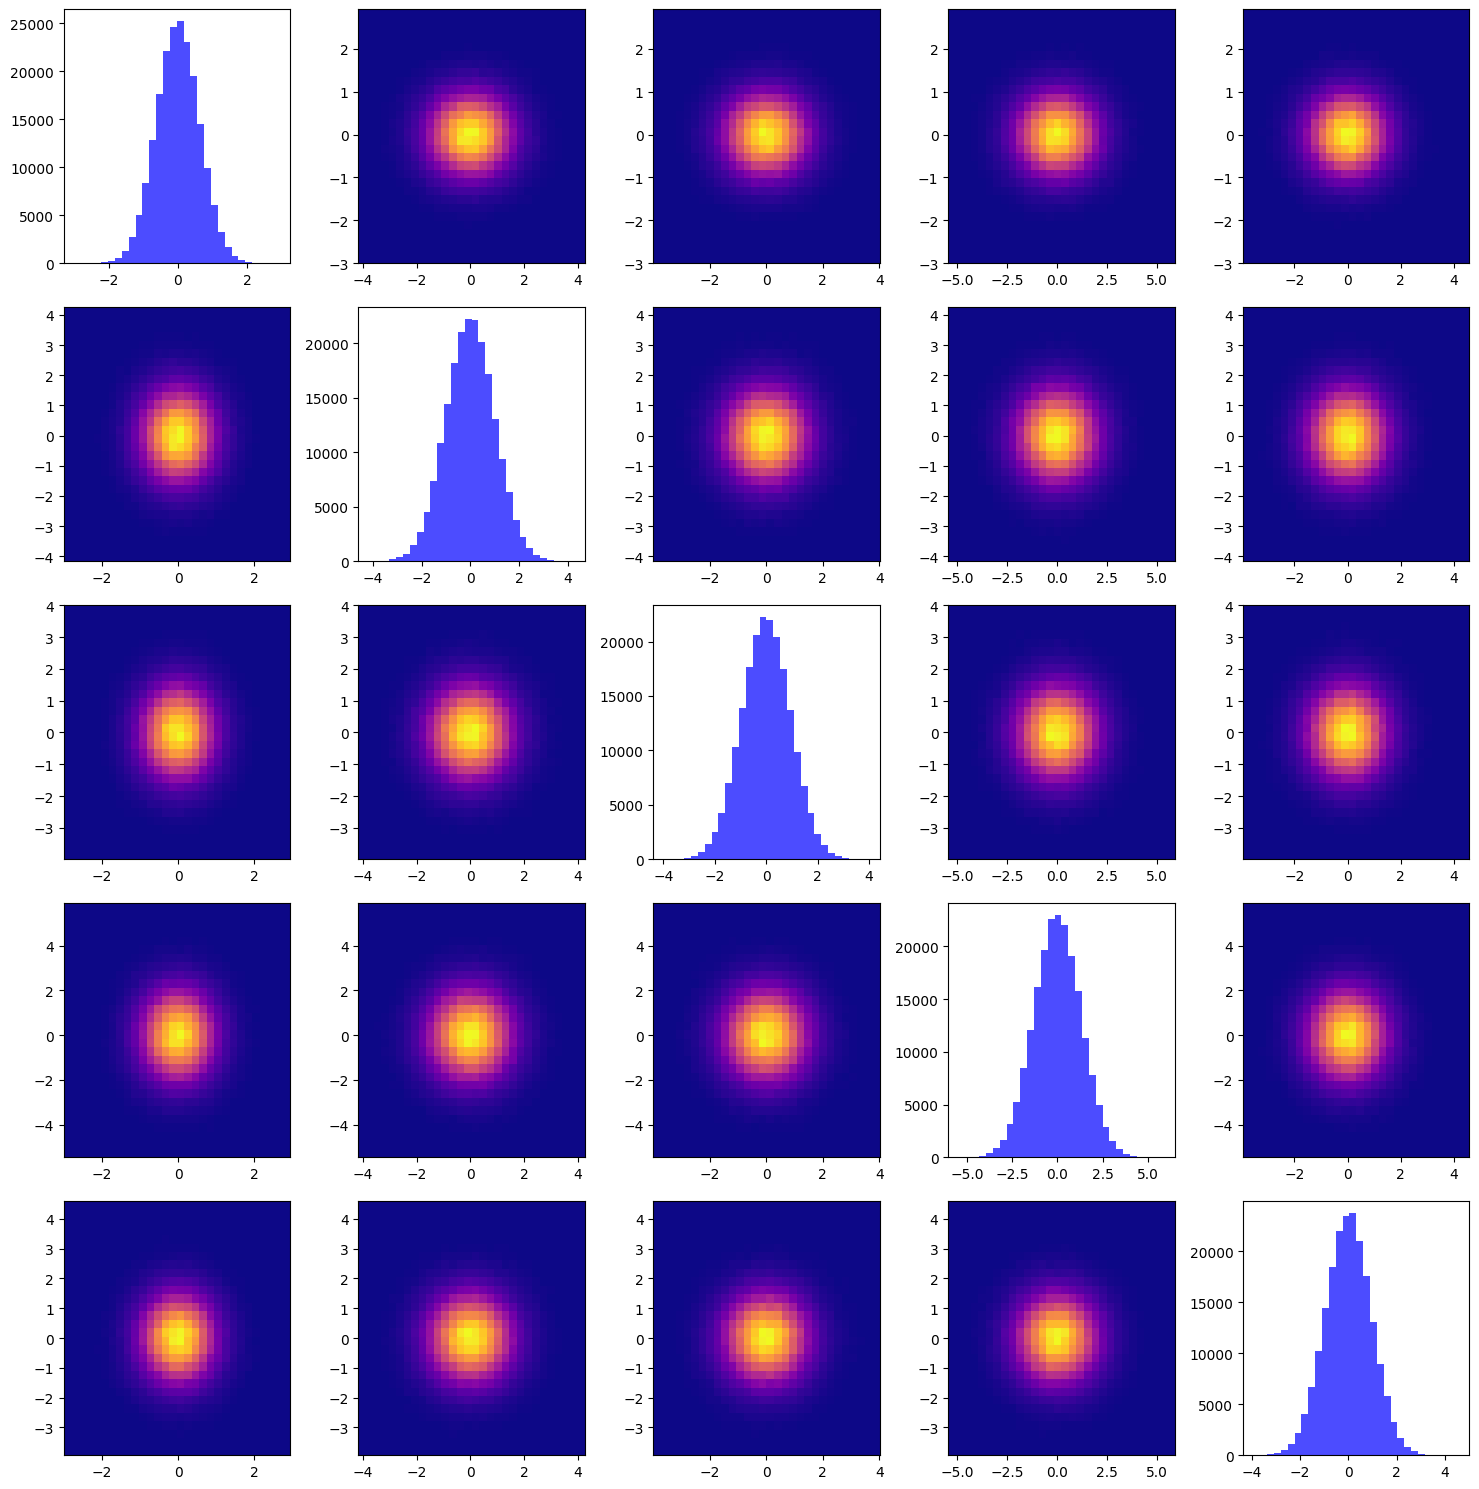

In [20]:

from dataset_class import SystematicDataset
# Instantiate the dataset
dataset = SystematicDataset(
    data_file='synthetic_double_gaussian_5D_eigenspace_weighted.npz', 
    start_conditional=2  # Example: treat first 2 dims as "conditional"
)

print("Number of samples:", len(dataset))
print("Data dimensionality:", dataset.ndim)

# Grab one sample
idx = 42
data_cond, data_rem, single_gauss_nll, neg_log_p = dataset[idx]

print(f"\nSample index {idx} =>")
print("  single_gaussian_log_density (standard Gauss NLL):", single_gauss_nll)
print("  negative_log_p (precomputed):", neg_log_p)

dataset.plot_histo_data(
    n_sample=200000, 
    n_bins=30, 
    eigen=True,       # If True, would plot in "eigenspace" = dataset.data
    true_reweight=True
)

dataset.plot_histo_data(
    n_sample=200000, 
    n_bins=30, 
    eigen=False,       # If True, would plot in "eigenspace" = dataset.data
    true_reweight=True
)

dataset.plot_histo_data(
    n_sample=200000, 
    n_bins=30, 
    eigen=False,       # If True, would plot in "eigenspace" = dataset.data
    true_reweight=False
)

In [21]:
data=np.load('../Dataset/pickle_files/test.pickle', allow_pickle = True) 

In [29]:
log_p=data['log_p']
np.exp(-np.array(log_p)/2)

array([1.60284453e-05, 1.32984798e-04, 1.12594194e-04, ...,
       5.12923899e-05, 5.28911424e-04, 2.05510380e-04])

In [30]:
data['data']

array([[ 1.34363944,  0.73559525, -0.27386373, ...,  0.79790969,
         0.71086423, -3.12264694],
       [ 0.0150248 ,  1.56319852, -0.71987954, ..., -1.07164092,
         1.5563634 ,  1.17913389],
       [-1.52653956,  0.05361495, -1.17789838, ...,  0.17949686,
         0.29736039, -0.23973024],
       ...,
       [ 1.17367996,  1.17855977,  0.14721747, ...,  1.6002563 ,
         0.41157661, -2.54712493],
       [-0.33594248,  0.30938179,  0.48341866, ..., -0.78268293,
         0.41964885, -1.22162211],
       [-0.59945027,  0.70495574, -1.24177399, ..., -0.64074827,
         2.01702393,  0.94674904]])

In [31]:
data['log_p']

[22.082291159727156,
 17.85055148024502,
 18.18344081115877,
 14.908823894729291,
 15.625251779837901,
 18.96896929774149,
 15.218414332137499,
 17.540971670296518,
 13.709741365151192,
 17.801112312001894,
 17.487258300692837,
 25.86146220783901,
 18.834637064713345,
 15.722560507832561,
 20.55411688878501,
 13.821217518414436,
 15.888193532866367,
 16.593869587862244,
 15.035851110640385,
 16.16829243261195,
 20.240483260488993,
 18.617049977542163,
 16.71607249942206,
 15.010094087788785,
 20.04310554094532,
 14.697611998871402,
 17.711351988590526,
 17.72635397126263,
 18.898638566925214,
 17.666177125415196,
 17.11340293134275,
 15.247666595613113,
 14.107000705070218,
 20.437559823519855,
 14.834008859277727,
 18.326932032146498,
 14.534945767817616,
 14.16532756787557,
 14.975097128716584,
 17.46676117019679,
 20.073964535013808,
 14.201974704551937,
 19.038799311219876,
 16.70026261474029,
 13.399741130730563,
 18.216088107489657,
 17.61259739911773,
 16.451718236810123,
 15.09